In [31]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

# models 
from sklearn.linear_model import LogisticRegression

#metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,f1_score, recall_score
from sklearn.model_selection import RepeatedStratifiedKFold

#smote 
from imblearn.over_sampling import SMOTE

# data
from sklearn.model_selection import train_test_split

#ignoring warnings
import warnings
warnings.filterwarnings('ignore')

#GridSearch
from sklearn.model_selection import GridSearchCV

#KNN
from sklearn.neighbors import KNeighborsClassifier

#Neural Networks
from sklearn.neural_network import MLPClassifier

#Naive Bayes 
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB

#Random Forest
from sklearn.ensemble import RandomForestClassifier

#Stacking
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score

#Decision Trees
from sklearn.tree import DecisionTreeClassifier

# Data Import and Split 

In [2]:
Train = pd.read_csv(r'../data/Train_year.csv', index_col=0)
y_Train = pd.read_csv(r'../data/y_Train_year.csv', index_col= 0)

Test = pd.read_csv(r'../data/Test_year.csv', index_col= 0)
y_Test = pd.read_csv(r'../data/y_Test_year.csv', index_col= 0)

In [39]:
features = ['ADR', 'LeadTime','StaysInWeekNights', 'TotalOfSpecialRequests',
        'BookingChanges', 'PreviousBookingsNotCanceled', 'RequiredCarParkingSpaces', 'PreviousCancellations',
        'x0_BB', 'x0_SC', 'x1_A', 'x1_B', 'x1_D',
       'x1_E', 'x1_F', 'x1_G', 'x2_avg_booker', 'x2_good_booker',
       'x2_low_booker', 'x2_no_booker', 'x2_super_booker', 'x3_Autumn',
       'x3_Spring', 'x3_Summer', 'x4_Low_Season','x5_frequent_foreigners', 'x5_portuguese',
        'x5_regular_foreigners']

# Functions to Test Models 

In [3]:
def metrics(X_train, X_val, y_train, pred_train , y_val, pred_val, model):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))
    print("Score: "+ str(model.score(X_train, y_train)))
    print("F1 Score: "+ str(f1_score(y_train, pred_train)))
    print("Recall: "+ str(recall_score(y_train, pred_train)))
    

    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))
    print("Score: "+ str(model.score(X_val, y_val)))
    print("F1 Score: "+ str(f1_score(y_val, pred_val)))
    print("Recall: "+ str(recall_score(y_val, pred_val)))

In [4]:
def avg_score(model, data_to_slice, y_to_slice, columns_to_use, smote = True):
    # apply kfold
    skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
    # create lists to store the results from the different models 
    score_train = []
    score_test = []
    f1_list = []
    recall_list =[]
    tn_avg = 0
    fp_avg = 0
    fn_avg = 0
    tp_avg = 0
    count = 0
    for train_index, test_index in skf.split(data_to_slice[columns_to_use],y_to_slice):
        # get the indexes of the observations assigned for each partition
        X_train, X_val = data_to_slice[columns_to_use].iloc[train_index], data_to_slice[columns_to_use].iloc[test_index]
        y_train, y_val = y_to_slice.iloc[train_index], y_to_slice.iloc[test_index]
        
        # SMOTE É AQUI 
        if smote:
             
            smote = SMOTE(random_state = 11)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        # applies the model 
        model_fit = model.fit(X_train, y_train)
        # predicts training 
        y_pred_train =  model_fit.predict(X_train)
        #predicts validation 
        y_pred_val = model_fit.predict(X_val)
        # prints metric results 
        
        #metrics(X_train, X_val, y_train, y_pred_train, y_val, y_pred_val, model)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_val).ravel()
        count += 1
        tn_avg += tn
        fp_avg += fp
        fn_avg += fn
        tp_avg += tp

        
        value_train = model.score(X_train, y_train)
        # check the mean accuracy for the test
        value_test = model.score(X_val,y_val)
        f1_score_val = f1_score(y_val, y_pred_val)
        recall_val = recall_score(y_val, y_pred_val)
        # append the accuracies, the time and the number of iterations in the corresponding list
        score_train.append(value_train)
        score_test.append(value_test)
        f1_list.append(f1_score_val)
        recall_list.append(recall_val)
  
    avg_train = round(np.mean(score_train),3)
    avg_test = round(np.mean(score_test),3)
    std_train = round(np.std(score_train),2)
    std_test = round(np.std(score_test),2)
    avg_f1 = round(np.mean(f1_list),3)
    std_f1 = round(np.std(f1_list),2)
    avg_recall = round(np.mean(recall_list),3)
    std_recall = round(np.std(recall_list),2)

    tn_avg = tn_avg / count
    fp_avg = fp_avg / count
    fn_avg = fn_avg / count
    tp_avg = tp_avg / count
    #print(confusion_matrix(y_val, y_pred_val))
    print(str(tp_avg)+ ' , ' + str(fp_avg) + '\n' + str(fn_avg) + ' , ' +  str(tn_avg))
    return str(avg_train) + '+/-' + str(std_train),\
            str(avg_test) + '+/-' + str(std_test) , str(avg_f1) + '+/-' + str(std_f1), avg_f1,\
                ' Recall: ' + str(avg_recall) + '+/-' + str(std_recall), avg_recall

## Logistic Regression

In [40]:
LogReg = LogisticRegression(random_state=11)

avg_score(LogReg, Train[features], y_Train,Train[features].columns, smote = True)


1392.8 , 1283.64
442.4 , 3501.56


('0.75+/-0.0',
 '0.739+/-0.0',
 '0.617+/-0.01',
 0.617,
 ' Recall: 0.759+/-0.01',
 0.759)

In [42]:
param_grid = {
    'penalty': ['l1','l2','elasticnet','none'],
    'dual':[True, False],
    'C':[0.05, 0.2, 0.5, 1, 2],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'max_iter': [50,100,200,500],
    'multi_class': ['auto', 'ovr', 'multinomial'],
    
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = LogReg, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_

{'C': 0.5,
 'dual': False,
 'max_iter': 100,
 'multi_class': 'multinomial',
 'penalty': 'l2',
 'solver': 'newton-cg'}

In [45]:
LogReg = LogisticRegression(random_state=11,C= 0.5,dual= False,max_iter= 100,
 multi_class= 'multinomial',penalty= 'l2', solver= 'newton-cg' )

avg_score(LogReg, Train[features], y_Train,Train[features].columns, smote = True)


1394.84 , 1283.84
440.36 , 3501.36


('0.75+/-0.0',
 '0.74+/-0.01',
 '0.618+/-0.01',
 0.618,
 ' Recall: 0.76+/-0.01',
 0.76)

In [28]:
# applies the model 
model_fit = LogReg.fit(Train, y_Train)
# predicts test 
y_pred_test =  model_fit.predict(Test)

In [29]:
print(len(y_pred_test))
print(y_pred_test.sum())

print(len(y_Test))
print(y_Test.sum())

20009
36
20009
IsCanceled    6826
dtype: int64


In [30]:
a = 0
for i,x in enumerate(y_Test.IsCanceled):
    if y_pred_test[i] == x:
        a+=1
a

13211

## KNN Classifier

In [18]:
modelKNN = KNeighborsClassifier()

avg_score(modelKNN, Train, y_Train,Train.columns, smote = True)

1271.24 , 1249.76
563.96 , 3535.44


('0.874+/-0.0',
 '0.726+/-0.01',
 '0.584+/-0.01',
 0.584,
 ' Recall: 0.693+/-0.01',
 0.693)

In [43]:
param_grid = {
    'n_neighbors': [5,10,50,100],
    'weights':['uniform', 'distance'],
    'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size': [10,30,50]
}
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = modelKNN, param_grid = param_grid, scoring = 'f1')

grid_search.fit(Train, y_Train)
grid_search.best_params_

{'algorithm': 'auto', 'leaf_size': 10, 'n_neighbors': 5, 'weights': 'uniform'}

In [46]:
modelKNN = KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto',
leaf_size= 10)

avg_score(modelKNN, Train[features], y_Train,features, smote = True)

1356.72 , 1113.92
478.48 , 3671.28


('0.889+/-0.0',
 '0.759+/-0.0',
 '0.63+/-0.01',
 0.63,
 ' Recall: 0.739+/-0.01',
 0.739)

In [47]:
# applies the model 
model_fit = modelKNN.fit(Train, y_Train)
# predicts test 
y_pred_test =  model_fit.predict(Test)

In [26]:
print(len(y_pred_test))
print(y_pred_test.sum())

print(len(y_Test))
print(y_Test.sum())

20009
4851
20009
IsCanceled    6826
dtype: int64


In [48]:
a = 0
for i,x in enumerate(y_Test.IsCanceled):
    if y_pred_test[i] == x:
        a+=1
a

14089

In [5]:
features_NN = ['ADR', 'Adults', 'ArrivalDateWeekNumber', 'BookingChanges',
       'LeadTime',
        'StaysInWeekNights',
       'PreviousCancellationRate',
       'TotalOfSpecialRequests','x2_avg_booker',
       'x2_good_booker', 'x2_low_booker', 'x2_no_booker', 'x2_super_booker',
       'x4_Low_Season']

In [6]:
modelNN=MLPClassifier()

avg_score(modelNN, Train[features_NN], y_Train,features_NN, smote = True)

1264.12 , 997.2
571.08 , 3788.0


('0.787+/-0.0',
 '0.763+/-0.01',
 '0.617+/-0.01',
 0.617,
 ' Recall: 0.689+/-0.02',
 0.689)

In [7]:
def Test_models (model, Train, y_Train, Test):
    model_fit = model.fit(Train, y_Train)
    y_pred_test = model_fit.predict(Test)
    a = 0
    for i,x in enumerate(y_Test.IsCanceled):
        if y_pred_test[i] == x:
            a+=1
    return(a)

# Stacking

In [22]:
modelKNN = KNeighborsClassifier(n_neighbors=5, weights='uniform',algorithm='auto',
leaf_size= 10)

LogReg = LogisticRegression(random_state=11,C= 0.5,dual= False,max_iter= 100,
 multi_class= 'multinomial',penalty= 'l2', solver= 'newton-cg' )

GNB = GaussianNB(var_smoothing= 0.003511191734215131)

rf_model = RandomForestClassifier(n_estimators=130, max_depth=15)


In [36]:
modelKNN_S = KNeighborsClassifier()

LogReg_S = LogisticRegression()

GNB_S = GaussianNB()

rf_model_S = RandomForestClassifier()

Dt_S =  DecisionTreeClassifier()

modelNN_S = MLPClassifier()



In [37]:
estimators = [('LR', LogReg_S), ('RFT', rf_model_S), ('NN', modelNN_S), ('GNB', GNB_S), ('DT', Dt_S)]

In [24]:
cv = RepeatedStratifiedKFold(n_splits = 5, n_repeats = 5, random_state = 1)

def return_f1score(model, X, y):
    n_scores = cross_val_score(model, Train, y_Train, scoring = 'f1', cv = cv)
    return n_scores

def return_results(models):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, Train, y_Train)
        print("Maximum Score: "+str(max(scores)))
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))
    
    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels = names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

Maximum Score: 0.3283009211873081
>auto 0.039 (0.061)
Maximum Score: 0.33244172716851356
>predict_proba 0.040 (0.062)
Maximum Score: nan
>decision_function nan (nan)
Maximum Score: 0.16209150326797384
>predict 0.038 (0.043)


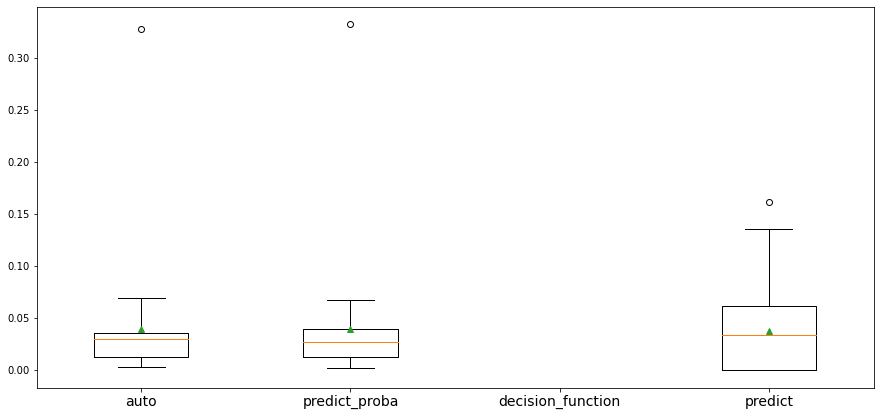

In [25]:
def get_models(values):
    models = dict()
    for value in values:
        models[str(value)] = StackingClassifier(estimators = estimators, stack_method= value)      
    return models

models = get_models(['auto', 'predict_proba', 'decision_function', 'predict'])
return_results(models)

In [26]:
modelST = StackingClassifier(estimators = estimators, stack_method= 'predict_proba')   

In [28]:
avg_score(modelST, Train, y_Train,Train.columns, smote = True)

1083.28 , 433.2
751.92 , 4352.0


('0.909+/-0.01',
 '0.821+/-0.01',
 '0.646+/-0.01',
 0.646,
 ' Recall: 0.59+/-0.03',
 0.59)

In [29]:
modelST = StackingClassifier(estimators = estimators)

avg_score(modelST, Train, y_Train,Train.columns, smote = True)

1093.64 , 427.6
741.56 , 4357.6


('0.911+/-0.01',
 '0.823+/-0.01',
 '0.651+/-0.01',
 0.651,
 ' Recall: 0.596+/-0.03',
 0.596)

In [38]:
modelST_S = StackingClassifier(estimators = estimators)

avg_score(modelST_S, Train, y_Train,Train.columns, smote = True)

1055.08 , 323.92
780.12 , 4461.28


('0.96+/-0.02',
 '0.833+/-0.01',
 '0.655+/-0.03',
 0.655,
 ' Recall: 0.575+/-0.06',
 0.575)

In [30]:
# applies the model 
model_fit = modelST.fit(Train, y_Train)
# predicts test 
y_pred_test =  model_fit.predict(Test)

a = 0
for i,x in enumerate(y_Test.IsCanceled):
    if y_pred_test[i] == x:
        a+=1
a

11169